In [13]:
import pandas as pd
import numpy as np
import os
os.chdir('D:/DataSet')

#### 数据读入

In [14]:
df = pd.read_csv('total_amt.csv',encoding='gbk')
df['report_date'] = pd.to_datetime(df['report_date'],format='%Y/%m/%d')
df.set_index('report_date', inplace=True)

In [15]:
base = pd.read_csv('./PRD/base.csv')
base['date'] = pd.to_datetime(base['date'], format='%Y%m%d')
base.set_index('date', inplace=True)

purchase_ratio = base.loc['2014-04':'2014-08-30', 'total_purchase_amt']
redeem_ratio = base.loc['2014-04':'2014-08-30', 'total_redeem_amt']

purchase_base = base.loc['2014-09-01':'2014-09-30',
                         'total_purchase_predicted_by_cycle']
redeem_base = base.loc['2014-09-01':'2014-09-30',
                         'total_redeem_predicted_by_cycle']

In [20]:
train = df.loc[:'2014-08-30',:].copy()
test = df.loc['2014-09-01':,:].copy()
purchase = train.pop('total_purchase_amt')
redeem = train.pop('total_redeem_amt')
test = test.drop(['total_purchase_amt', 'total_redeem_amt'], axis=1)

In [21]:
train.fillna(0).corrwith(purchase)

weekday                     -0.654226
一周正常第1/5天上班                  0.390184
周末第几天                       -0.604825
休假第1/3天                     -0.660504
休假前正常上班的一天                  -0.097087
休假后正常上班的一天                   0.274026
上班前一天休假                      0.274026
工作日                          0.716887
休假                          -0.716887
是否月初                         0.158812
是否月中                         0.013399
每月第一天                        0.127810
申购上一个波峰是几天前                  0.178945
申购上一个波谷是几天前                 -0.430076
赎回上一个波峰是几天前                 -0.129879
赎回上一个波谷是几天前                 -0.181845
上班最后天后要放2天假（2-3,7 3个01特征）    0.019134
上班最后天后要放3天假（2-3,7 3个01特征）   -0.019134
上班第一天前放了2天假（2-3 2个01特征）     -0.177181
两天的假                        -0.597426
三天的假                        -0.309095
周日补班                              NaN
新股发售                         0.129749
dtype: float64

In [ ]:
delete=['休假前正常上班的一天','是否月中','上班最后天后要放2天假（2-3,7 3个01特征）',
 '上班最后天后要放3天假（2-3,7 3个01特征）','周日补班']
train.drop(delete, axis=1, inplace=True)

In [31]:
test.drop(delete, axis=1, inplace=True)

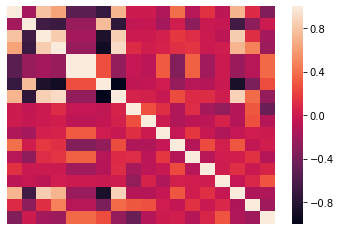

In [25]:
import seaborn as sns
%matplotlib inline
sns.heatmap(train.corr(),xticklabels=False,yticklabels=False)

In [27]:
train.drop(['工作日'],axis=1, inplace=True)
test.drop(['工作日'],axis=1, inplace=True)

#### 建立模型

In [32]:
from sklearn import linear_model as lm
model = lm.LinearRegression()
model = model.fit(train.fillna(0), purchase)
pur = model.predict(test.fillna(0))
model1 = lm.LinearRegression()
model1 = model1.fit(train.fillna(0), redeem)
red = model1.predict(test.fillna(0))

In [106]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(num_leaves=10,
    max_depth=2,
    learning_rate=0.01,
    n_estimators=500,)
res = model.fit(train.to_numpy(), purchase)

predpur = res.predict(test.to_numpy())

model1 = LGBMRegressor(num_leaves=10,
    max_depth=2,
    learning_rate=0.01,
    n_estimators=500,)
res1 = model1.fit(train.to_numpy(), redeem)
predred = res.predict(test.to_numpy())

In [33]:
def to_result(purchase, redeem):
    report_date=list(range(20140901,20140931))
    sub=pd.DataFrame()
    sub['purchase']=purchase
    sub['redeem']=redeem
    sub=sub.reset_index()
    sub['index']=report_date
    sub=sub.rename(columns={'index':'report_date'})
    sub[['purchase','redeem']]=sub[['purchase','redeem']].astype(np.int64)
    sub=sub.set_index(['report_date'])
    sub.to_csv('tc_comp_predict_table5.csv',sep=',')
    
to_result(pur, red)

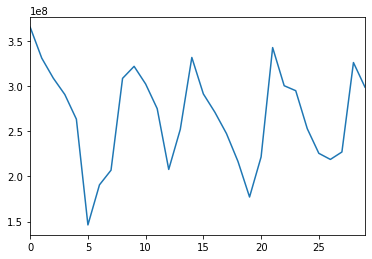

In [34]:
pd.Series(pur).plot()

In [ ]:
import json
import os

from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, fbeta_score)

def get_metrics(y, y_pred, beta=2, average_method='macro', y_encoder=None):
    if y_encoder:
        y = y_encoder.inverse_transform(y)
        y_pred = y_encoder.inverse_transform(y_pred)
    return {
        'accuracy': round(accuracy_score(y, y_pred), 4),
        'f1_score_macro': round(f1_score(y, y_pred, average=average_method), 4),
        'fbeta_score_macro': round(fbeta_score(y, y_pred, beta, average=average_method), 4),
        'report': classification_report(y, y_pred, output_dict=True),
        'report_csv': classification_report(y, y_pred, output_dict=False).replace('\n','\r\n')
    }


def save_metrics(metrics: dict, model_directory, file_name):
    path = os.path.join(model_directory, file_name + '_report.txt')
    classification_report_to_csv(metrics['report_csv'], path)
    metrics.pop('report_csv')
    path = os.path.join(model_directory, file_name + '_metrics.json')
    json.dump(metrics, open(path, 'w'), indent=4)